# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import fit_linP
import likelihood
import emcee_sampler

### Setup emulator

In [2]:
basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label=None
skewers_label=None
undersample_z=3
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [3]:
# specify free parameters in likelihood
free_parameters=['ln_tau_0','Delta2_star']

In [4]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
setup with 20 walkers
set 20 walkers with 2 dimensions
done setting up sampler


In [5]:
for p in sampler.like.free_params:
    print(p.name,p.value)

Delta2_star 0.360175905286
ln_tau_0 -0.794580172414


In [6]:
# debug sampler, but not likelihood
sampler.like.go_silent()
sampler.verbose=True

### Run burn-in and main MCMC chains

In [7]:
sampler.run_burn_in(nsteps=50)

start burn-in, will do 50 steps
0 [ 0.56725421  0.53362009]
20 [ 0.45738362  0.35984663]
40 [ 0.11972809  0.4139006 ]
finished burn-in


In [8]:
sampler.run_chains(nsteps=200)

0 [ 0.60630099  0.54783583]
20 [ 0.40720823  0.37544075]
40 [ 0.11469521  0.41528147]
60 [ 0.02860613  0.43582469]
80 [ 0.00573129  0.44590964]
100 [ 0.00206996  0.44590634]
120 [ 0.00103177  0.44558575]
140 [ 0.00111754  0.44538056]
160 [ 0.00080425  0.44644564]
180 [ 0.00065186  0.44475224]


In [9]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.540


### Plot main results from chains (with dimension parameters)

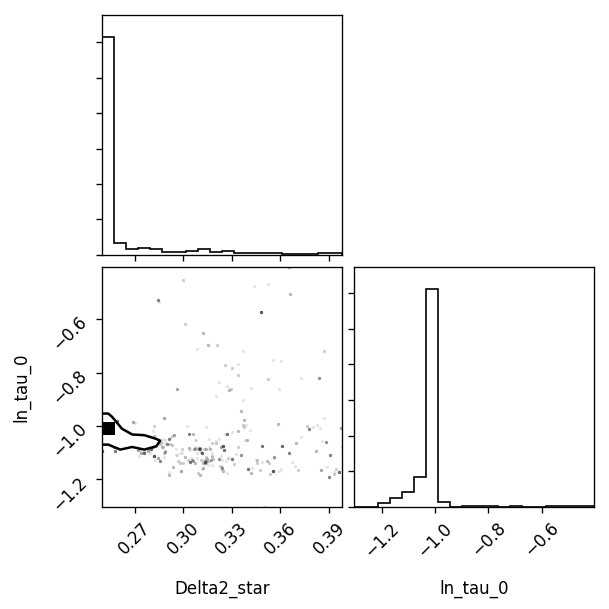

In [10]:
sampler.plot_corner(cube=False)

### Use likelihood object to make several useful plots

In [11]:
# get mean of chain
mcmc_mean=np.mean(sampler.sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.08430361  0.4373344 ]


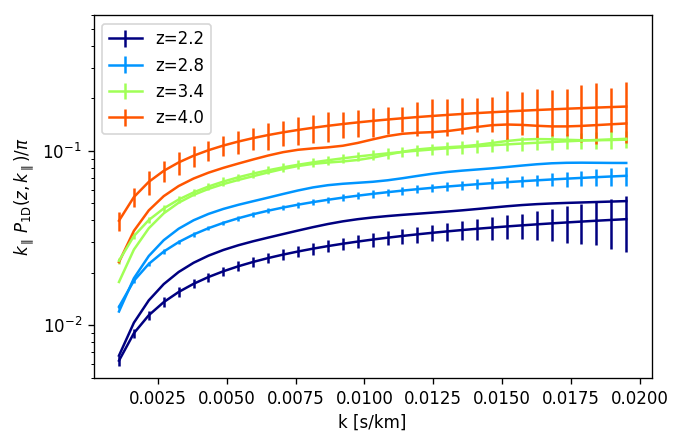

In [12]:
sampler.like.plot_p1d(values=mcmc_mean,plot_every_iz=3)

In [13]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.sampler.lnprobability, axis=None), sampler.sampler.lnprobability.shape)
best_fit=sampler.sampler.chain[ind]

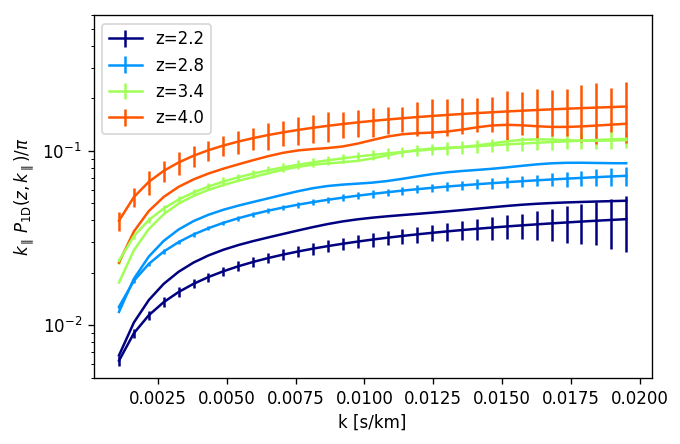

In [14]:
sampler.like.plot_p1d(values=best_fit,plot_every_iz=3)

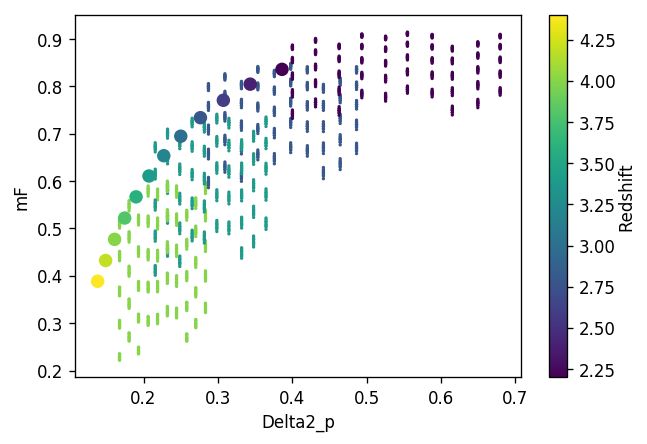

In [15]:
sampler.like.overplot_emulator_calls('Delta2_p','mF',values=best_fit)